Procesando usuarios: 100%|██████████| 1/1 [00:09<00:00,  9.80s/it]



Errores de validación (2024) por usuario:
   usuario        MAE          MSE       RMSE
0       10  40.783463  2673.021443  51.701271
CSV generado: consumo_real_vs_pred_arima_usuario_10_2024.csv


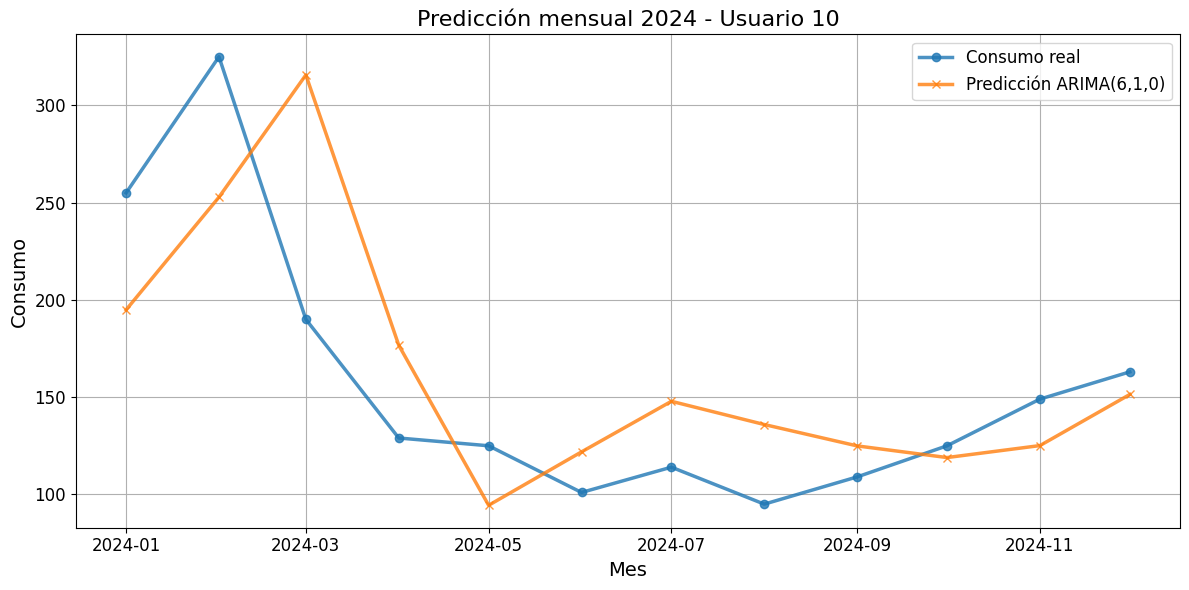

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# =========================
# PARAMETROS DE ESTILO (EDITABLES)
# =========================
STYLE = {
    # Tamaños de texto
    "fontsize_title": 16,
    "fontsize_axes": 14,
    "fontsize_ticks": 12,
    "fontsize_legend": 12,

    # Grosor de líneas
    "linewidth_real": 2.5,
    "linewidth_pred": 2.5,

    # Marcadores (opcional)
    "markersize_real": 6,
    "markersize_pred": 6,

    # Otros (opcional)
    "alpha": 0.8
}

# 1. Cargar archivo con formato europeo
df = pd.read_csv("CON_TEMPU1.csv", sep=';', decimal=',')

# 2. Crear columna fecha
df['fecha'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str).str.zfill(2) + '-01')
df.sort_values(['usuario', 'fecha'], inplace=True)

# 3. Rango de fechas a validar
fechas_2024 = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

# 4. Inicializar estructuras
errores = []
usuario_ejemplo = df['usuario'].unique()[0]  # Elegimos uno para graficar

pred_2024_ej, real_2024_ej = None, None  # por seguridad

for usuario in tqdm(df['usuario'].unique(), desc="Procesando usuarios"):
    df_user = df[df['usuario'] == usuario].copy()
    df_user.set_index('fecha', inplace=True)
    df_user = df_user.asfreq('MS')  # Frecuencia mensual explícita

    serie = df_user['consumo']
    preds, reales = [], []

    for fecha in fechas_2024:
        serie_entrenamiento = serie[serie.index < fecha]

        try:
            modelo = ARIMA(serie_entrenamiento, order=(6, 1, 0))
            modelo_fit = modelo.fit()
            pred = modelo_fit.forecast().iloc[0]
            real = serie[fecha]
        except Exception:
            pred, real = np.nan, np.nan

        preds.append(pred)
        reales.append(real)

    # Cálculo de errores
    mask = ~np.isnan(preds)
    if mask.sum() > 0:
        mae = mean_absolute_error(np.array(reales)[mask], np.array(preds)[mask])
        mse = mean_squared_error(np.array(reales)[mask], np.array(preds)[mask])
        rmse = np.sqrt(mse)
    else:
        mae = mse = rmse = np.nan

    errores.append({'usuario': usuario, 'MAE': mae, 'MSE': mse, 'RMSE': rmse})

    # Guardamos los datos para el gráfico del usuario ejemplo
    if usuario == usuario_ejemplo:
        pred_2024_ej = preds
        real_2024_ej = reales

# 5. Mostrar tabla de errores
df_errores = pd.DataFrame(errores)
print("\nErrores de validación (2024) por usuario:")
print(df_errores)

# -------------------------
# 5.b EXPORTAR CSV (lo que se grafica)
# -------------------------
df_export = pd.DataFrame({
    "fecha": fechas_2024,
    "consumo_real": real_2024_ej,
    "pred_arima_6_1_0": pred_2024_ej
})

# Formateo: fecha y 2 decimales con coma decimal
df_export["fecha"] = pd.to_datetime(df_export["fecha"]).dt.strftime("%Y-%m-%d")

def fmt_2dec_coma(x):
    if pd.isna(x):
        return ""      # vacío si no hay dato/predicción
    return f"{x:.2f}".replace(".", ",")

for c in ["consumo_real", "pred_arima_6_1_0"]:
    df_export[c] = df_export[c].apply(fmt_2dec_coma)

output_file = f"consumo_real_vs_pred_arima_usuario_{usuario_ejemplo}_2024.csv"
df_export.to_csv(output_file, sep=";", index=False)

print("CSV generado:", output_file)

# 6. Graficar predicciones vs reales SOLO 2024 para un usuario
plt.figure(figsize=(12, 6))

plt.plot(
    fechas_2024, real_2024_ej,
    label='Consumo real',
    marker='o',
    markersize=STYLE["markersize_real"],
    linewidth=STYLE["linewidth_real"],
    alpha=STYLE["alpha"]
)

plt.plot(
    fechas_2024, pred_2024_ej,
    label='Predicción ARIMA(6,1,0)',
    marker='x',
    markersize=STYLE["markersize_pred"],
    linewidth=STYLE["linewidth_pred"],
    alpha=STYLE["alpha"]
)

plt.title(f"Predicción mensual 2024 - Usuario {usuario_ejemplo}", fontsize=STYLE["fontsize_title"])
plt.xlabel("Mes", fontsize=STYLE["fontsize_axes"])
plt.ylabel("Consumo", fontsize=STYLE["fontsize_axes"])

plt.xticks(fontsize=STYLE["fontsize_ticks"])
plt.yticks(fontsize=STYLE["fontsize_ticks"])

plt.legend(fontsize=STYLE["fontsize_legend"])
plt.grid(True)
plt.tight_layout()
plt.show()
